In [93]:
# [1]包导入                            # 特征工程+XGBT+Grid： 效果反而变差了，但是是一个完整的流程噢
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import missingno as msno
import warnings
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [94]:
# 在数据探索，填充，特征衍生，特征筛选，繁琐流程之后，做的结果反而没有单纯的XGBT全特征效果好。

In [95]:
# [2]全局变量
TARGET='销售价格'
oTARGET='SalePrice'
# 设置支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体支持中文
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
# 屏蔽此类警告
import warnings
warnings.filterwarnings("ignore", message="Could not find the number of physical cores")
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # 或其他你机器的逻辑核心数

In [96]:
# [3]数据集读取
otrain_data = pd.read_csv('train.csv')
otest_data = pd.read_csv('test.csv')
train_data = otrain_data.copy()
test_data = otest_data.copy()         # 原始数据备份
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [97]:
# EDA

# 对比train和test的数据类型，不同大类需要转换（数值型，字串型object，bool型）
# 将标签值SalePrice去除，然后使用pandas的compare将两个dataframe进行比较：会将不同的类型列出来
train_dtypes = train_data.dtypes
test_dtypes = test_data.dtypes
train_dtype = train_dtypes.drop(oTARGET)
train_dtype.compare(test_dtypes)

,self,other
BsmtFinSF1,int64,float64
BsmtFinSF2,int64,float64
BsmtUnfSF,int64,float64
TotalBsmtSF,int64,float64
BsmtFullBath,int64,float64
BsmtHalfBath,int64,float64
GarageCars,int64,float64
GarageArea,int64,float64


In [98]:
# EDA

# [4]换表头 注意：train和test都要换
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [99]:
train_data.rename(columns={
    'Id': '编号',
    'MSSubClass': '建筑分类',
    'MSZoning': '区域分类',
    'LotFrontage': '临街长度',
    'LotArea': '地块面积',
    'Street': '街道类型',
    'Alley': '小巷类型',
    'LotShape': '地块形状',
    'LandContour': '地势类型',
    'Utilities': '公共设施',
    'LotConfig': '地块配置',
    'LandSlope': '地势坡度',
    'Neighborhood': '街区',
    'Condition1': '主路状况',
    'Condition2': '次路状况',
    'BldgType': '建筑类型',
    'HouseStyle': '住宅风格',
    'OverallQual': '整体材质',
    'OverallCond': '整体状况',
    'YearBuilt': '建造年份',
    'YearRemodAdd': '翻新年份',
    'RoofStyle': '屋顶样式',
    'RoofMatl': '屋顶材料',
    'Exterior1st': '外部材料1',
    'Exterior2nd': '外部材料2',
    'MasVnrType': '砌面类型',
    'MasVnrArea': '砌面面积',
    'ExterQual': '外部质量',
    'ExterCond': '外部状况',
    'Foundation': '地基类型',
    'BsmtQual': '地下室高度',
    'BsmtCond': '地下室状况',
    'BsmtExposure': '地下室采光',
    'BsmtFinType1': '地下室装修类型1',
    'BsmtFinSF1': '地下室装修面积1',
    'BsmtFinType2': '地下室装修类型2',
    'BsmtFinSF2': '地下室装修面积2',
    'BsmtUnfSF': '地下室未装修面积',
    'TotalBsmtSF': '地下室总面积',
    'Heating': '供暖类型',
    'HeatingQC': '供暖质量',
    'CentralAir': '中央空调',
    'Electrical': '电气系统',
    '1stFlrSF': '一层面积',
    '2ndFlrSF': '二层面积',
    'LowQualFinSF': '低质量装修面积',
    'GrLivArea': '地上生活面积',
    'BsmtFullBath': '地下室全卫',
    'BsmtHalfBath': '地下室半卫',
    'FullBath': '全卫数量',
    'HalfBath': '半卫数量',
    'BedroomAbvGr': '地上卧室数',
    'KitchenAbvGr': '地上厨房数',
    'KitchenQual': '厨房质量',
    'TotRmsAbvGrd': '地上房间数',
    'Functional': '功能性评级',
    'Fireplaces': '壁炉数量',
    'FireplaceQu': '壁炉质量',
    'GarageType': '车库类型',
    'GarageYrBlt': '车库建造年',
    'GarageFinish': '车库装修情况',
    'GarageCars': '车库车位数',
    'GarageArea': '车库面积',
    'GarageQual': '车库质量',
    'GarageCond': '车库状况',
    'PavedDrive': '铺装车道',
    'WoodDeckSF': '木质甲板面积',
    'OpenPorchSF': '开放式门廊面积',
    'EnclosedPorch': '封闭式门廊面积',
    '3SsnPorch': '三季门廊面积',
    'ScreenPorch': '纱窗门廊面积',
    'PoolArea': '泳池面积',
    'PoolQC': '泳池质量',
    'Fence': '围栏质量',
    'MiscFeature': '杂项设施',
    'MiscVal': '杂项价值',
    'MoSold': '售出月份',
    'YrSold': '售出年份',
    'SaleType': '销售类型',
    'SaleCondition': '销售条件',
    'SalePrice': '销售价格'
}, inplace=True)
test_data.rename(columns={
    'Id': '编号',
    'MSSubClass': '建筑分类',
    'MSZoning': '区域分类',
    'LotFrontage': '临街长度',
    'LotArea': '地块面积',
    'Street': '街道类型',
    'Alley': '小巷类型',
    'LotShape': '地块形状',
    'LandContour': '地势类型',
    'Utilities': '公共设施',
    'LotConfig': '地块配置',
    'LandSlope': '地势坡度',
    'Neighborhood': '街区',
    'Condition1': '主路状况',
    'Condition2': '次路状况',
    'BldgType': '建筑类型',
    'HouseStyle': '住宅风格',
    'OverallQual': '整体材质',
    'OverallCond': '整体状况',
    'YearBuilt': '建造年份',
    'YearRemodAdd': '翻新年份',
    'RoofStyle': '屋顶样式',
    'RoofMatl': '屋顶材料',
    'Exterior1st': '外部材料1',
    'Exterior2nd': '外部材料2',
    'MasVnrType': '砌面类型',
    'MasVnrArea': '砌面面积',
    'ExterQual': '外部质量',
    'ExterCond': '外部状况',
    'Foundation': '地基类型',
    'BsmtQual': '地下室高度',
    'BsmtCond': '地下室状况',
    'BsmtExposure': '地下室采光',
    'BsmtFinType1': '地下室装修类型1',
    'BsmtFinSF1': '地下室装修面积1',
    'BsmtFinType2': '地下室装修类型2',
    'BsmtFinSF2': '地下室装修面积2',
    'BsmtUnfSF': '地下室未装修面积',
    'TotalBsmtSF': '地下室总面积',
    'Heating': '供暖类型',
    'HeatingQC': '供暖质量',
    'CentralAir': '中央空调',
    'Electrical': '电气系统',
    '1stFlrSF': '一层面积',
    '2ndFlrSF': '二层面积',
    'LowQualFinSF': '低质量装修面积',
    'GrLivArea': '地上生活面积',
    'BsmtFullBath': '地下室全卫',
    'BsmtHalfBath': '地下室半卫',
    'FullBath': '全卫数量',
    'HalfBath': '半卫数量',
    'BedroomAbvGr': '地上卧室数',
    'KitchenAbvGr': '地上厨房数',
    'KitchenQual': '厨房质量',
    'TotRmsAbvGrd': '地上房间数',
    'Functional': '功能性评级',
    'Fireplaces': '壁炉数量',
    'FireplaceQu': '壁炉质量',
    'GarageType': '车库类型',
    'GarageYrBlt': '车库建造年',
    'GarageFinish': '车库装修情况',
    'GarageCars': '车库车位数',
    'GarageArea': '车库面积',
    'GarageQual': '车库质量',
    'GarageCond': '车库状况',
    'PavedDrive': '铺装车道',
    'WoodDeckSF': '木质甲板面积',
    'OpenPorchSF': '开放式门廊面积',
    'EnclosedPorch': '封闭式门廊面积',
    '3SsnPorch': '三季门廊面积',
    'ScreenPorch': '纱窗门廊面积',
    'PoolArea': '泳池面积',
    'PoolQC': '泳池质量',
    'Fence': '围栏质量',
    'MiscFeature': '杂项设施',
    'MiscVal': '杂项价值',
    'MoSold': '售出月份',
    'YrSold': '售出年份',
    'SaleType': '销售类型',
    'SaleCondition': '销售条件',
    'SalePrice': '销售价格'
}, inplace=True)


In [100]:
train_data.head(5)

,编号,建筑分类,区域分类,临街长度,地块面积,街道类型,小巷类型,地块形状,地势类型,公共设施,...,泳池面积,泳池质量,围栏质量,杂项设施,杂项价值,售出月份,售出年份,销售类型,销售条件,销售价格
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [101]:
# [5]筛选训练集和测试集都存在的列
cols = [TARGET]         # target列一定保留
for c in train_data.columns:
    if c in test_data.columns:
        cols.append(c)
train_data = train_data[cols]
test_data = test_data[cols[1:]]        # test_data不包含结果列

In [102]:
train_data.head(5)

,销售价格,编号,建筑分类,区域分类,临街长度,地块面积,街道类型,小巷类型,地块形状,地势类型,...,纱窗门廊面积,泳池面积,泳池质量,围栏质量,杂项设施,杂项价值,售出月份,售出年份,销售类型,销售条件
0,208500,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,181500,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,223500,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,140000,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,250000,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [103]:
# 将非数据类 列的数据类型改为category类型， 即为object字符串

# 获取所有非数值类型的列
# non_numerical_cols = train_data.select_dtypes(exclude=['float64', 'int64']).columns
#
# # 将所有非数值类型的列转换为category类型
# for col in non_numerical_cols:
#     train_data[col] = train_data[col].astype('category')
#     test_data[col] = test_data[col].astype('category')

In [104]:
test_data.head(5)

,编号,建筑分类,区域分类,临街长度,地块面积,街道类型,小巷类型,地块形状,地势类型,公共设施,...,纱窗门廊面积,泳池面积,泳池质量,围栏质量,杂项设施,杂项价值,售出月份,售出年份,销售类型,销售条件
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [105]:
# [6] 查看单变量统计特性
train_data[TARGET].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: 销售价格, dtype: float64

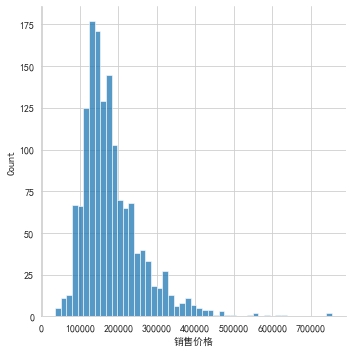

In [106]:
sns.displot(train_data[TARGET])

In [107]:
# [7] 查看每一列的缺失程度并处理
# 查看每一列的缺失值数量和缺失比例
missing_info = train_data.isnull().sum().to_frame(name='缺失数量')
missing_info['缺失比例'] = (missing_info['缺失数量'] / len(train_data)) * 100
missing_info = missing_info[missing_info['缺失数量'] > 0]
missing_info.sort_values(by='缺失比例', ascending=False, inplace=True)

print(missing_info)
print()
print('共计%d列'%len(missing_info))

          缺失数量       缺失比例
泳池质量      1453  99.520548
杂项设施      1406  96.301370
小巷类型      1369  93.767123
围栏质量      1179  80.753425
壁炉质量       690  47.260274
临街长度       259  17.739726
车库类型        81   5.547945
车库建造年       81   5.547945
车库装修情况      81   5.547945
车库质量        81   5.547945
车库状况        81   5.547945
地下室采光       38   2.602740
地下室装修类型2    38   2.602740
地下室装修类型1    37   2.534247
地下室状况       37   2.534247
地下室高度       37   2.534247
砌面面积         8   0.547945
砌面类型         8   0.547945
电气系统         1   0.068493

共计19列


In [108]:
# test_data
missing_info = test_data.isnull().sum().to_frame(name='缺失数量')
missing_info['缺失比例'] = (missing_info['缺失数量'] / len(test_data)) * 100
missing_info = missing_info[missing_info['缺失数量'] > 0]
missing_info.sort_values(by='缺失比例', ascending=False, inplace=True)

print(missing_info)
print()
print('共计%d列'%len(missing_info))

          缺失数量       缺失比例
泳池质量      1456  99.794380
杂项设施      1408  96.504455
小巷类型      1352  92.666210
围栏质量      1169  80.123372
壁炉质量       730  50.034270
临街长度       227  15.558602
车库状况        78   5.346127
车库建造年       78   5.346127
车库质量        78   5.346127
车库装修情况      78   5.346127
车库类型        76   5.209047
地下室状况       45   3.084304
地下室采光       44   3.015764
地下室高度       44   3.015764
地下室装修类型1    42   2.878684
地下室装修类型2    42   2.878684
砌面类型        16   1.096642
砌面面积        15   1.028101
区域分类         4   0.274160
地下室全卫        2   0.137080
地下室半卫        2   0.137080
功能性评级        2   0.137080
公共设施         2   0.137080
车库车位数        1   0.068540
车库面积         1   0.068540
地下室总面积       1   0.068540
厨房质量         1   0.068540
地下室未装修面积     1   0.068540
地下室装修面积2     1   0.068540
地下室装修面积1     1   0.068540
外部材料2        1   0.068540
外部材料1        1   0.068540
销售类型         1   0.068540

共计33列


In [109]:
# 缺失比例超过80%的列直接删除， 注意：只要是train_data缺失80%的列即可删除。

# 计算每列的缺失比例
missing_ratio = train_data.isnull().mean()
# 找出缺失比例超过 80% 的列
cols_to_drop = missing_ratio[missing_ratio > 0.8].index
# 删除这些列
train_data.drop(columns=cols_to_drop, inplace=True)
test_data.drop(columns=cols_to_drop, inplace=True)
print(f'已删除 {len(cols_to_drop)} 列，缺失率超过80%。')

已删除 4 列，缺失率超过80%。


In [110]:
test_data.head(5)

,编号,建筑分类,区域分类,临街长度,地块面积,街道类型,地块形状,地势类型,公共设施,地块配置,...,开放式门廊面积,封闭式门廊面积,三季门廊面积,纱窗门廊面积,泳池面积,杂项价值,售出月份,售出年份,销售类型,销售条件
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,82,0,0,144,0,0,1,2010,WD,Normal


In [111]:
# [8] 删除唯一值占比超过95%的列

# 设置阈值，比如95%以上的值相同就认为是无效特征
threshold = 0.95

# 找出唯一值比例过高的列
constant_cols = [col for col in train_data.columns
                 if train_data[col].value_counts(normalize=True, dropna=False).values[0] > threshold]
# 删除这些列
train_data.drop(columns=constant_cols, inplace=True)
test_data.drop(columns=constant_cols, inplace=True)

print(f'已删除 {len(constant_cols)} 列，值几乎恒定（>{threshold*100:.0f}% 相同）。')

已删除 10 列，值几乎恒定（>95% 相同）。


In [112]:
train_data.head(5)

,销售价格,编号,建筑分类,区域分类,临街长度,地块面积,地块形状,地势类型,地块配置,地势坡度,...,车库状况,铺装车道,木质甲板面积,开放式门廊面积,封闭式门廊面积,纱窗门廊面积,售出月份,售出年份,销售类型,销售条件
0,208500,1,60,RL,65.0,8450,Reg,Lvl,Inside,Gtl,...,TA,Y,0,61,0,0,2,2008,WD,Normal
1,181500,2,20,RL,80.0,9600,Reg,Lvl,FR2,Gtl,...,TA,Y,298,0,0,0,5,2007,WD,Normal
2,223500,3,60,RL,68.0,11250,IR1,Lvl,Inside,Gtl,...,TA,Y,0,42,0,0,9,2008,WD,Normal
3,140000,4,70,RL,60.0,9550,IR1,Lvl,Corner,Gtl,...,TA,Y,0,35,272,0,2,2006,WD,Abnorml
4,250000,5,60,RL,84.0,14260,IR1,Lvl,FR2,Gtl,...,TA,Y,192,84,0,0,12,2008,WD,Normal


In [113]:
test_data.head(5)

,编号,建筑分类,区域分类,临街长度,地块面积,地块形状,地势类型,地块配置,地势坡度,街区,...,车库状况,铺装车道,木质甲板面积,开放式门廊面积,封闭式门廊面积,纱窗门廊面积,售出月份,售出年份,销售类型,销售条件
0,1461,20,RH,80.0,11622,Reg,Lvl,Inside,Gtl,NAmes,...,TA,Y,140,0,0,120,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,IR1,Lvl,Corner,Gtl,NAmes,...,TA,Y,393,36,0,0,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,IR1,Lvl,Inside,Gtl,Gilbert,...,TA,Y,212,34,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,IR1,Lvl,Inside,Gtl,Gilbert,...,TA,Y,360,36,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,IR1,HLS,Inside,Gtl,StoneBr,...,TA,Y,0,82,0,144,1,2010,WD,Normal


In [114]:
# [9]填充缺失值

# 查看缺失值的数量、比例和数据类型
missing_info = pd.DataFrame({
    '缺失数量': train_data.isnull().sum(),
    '缺失比例': train_data.isnull().mean(),
    '数据类型': train_data.dtypes
})

# 只保留有缺失值的列
missing_info = missing_info[missing_info['缺失数量'] > 0]

# 按缺失比例降序排序，方便查看最严重的缺失列
missing_info.sort_values(by='缺失比例', ascending=False, inplace=True)

# 显示结果
print(missing_info)

          缺失数量      缺失比例     数据类型
壁炉质量       690  0.472603   object
临街长度       259  0.177397  float64
车库类型        81  0.055479   object
车库建造年       81  0.055479  float64
车库装修情况      81  0.055479   object
车库质量        81  0.055479   object
车库状况        81  0.055479   object
地下室采光       38  0.026027   object
地下室装修类型2    38  0.026027   object
地下室高度       37  0.025342   object
地下室状况       37  0.025342   object
地下室装修类型1    37  0.025342   object
砌面类型         8  0.005479   object
砌面面积         8  0.005479  float64
电气系统         1  0.000685   object


填充的原则：
1. 数值型
均值填充适用于分布较为平滑的数据。

中位数填充适用于有较大离群点的分布，避免极端值的影响。

零填充可以用于表示无值的情况，例如“车库建造年”可以视为“未知年”，填充为0。

2. 分类型
众数填充：适合填充缺失较少的分类特征。

“未知”标记填充：如果某些特征的缺失对模型预测有特殊意义，可以考虑将缺失值用“未知”或“缺失”标记。


In [115]:
# 辅助：查看某一列各个值的频数
train_data['车库装修情况'].value_counts()

Unf    605
RFn    422
Fin    352
Name: 车库装修情况, dtype: int64

In [116]:
# 要按照实际情况来填

# 数值类型列
# 均值填充
mean_set = ['临街长度', '车库建造年']
# 0填充
zero_set = ['砌面面积']

# object类型列
# 填充的实际意义为：没有
nohave_set = ['壁炉质量', '车库类型', '车库装修情况', '车库质量', '车库状况', '地下室装修类型2', '地下室采光', '地下室高度', '地下室状况', '地下室装修类型1', '砌面类型', '电气系统']

for col in mean_set:
    train_data[col].fillna(train_data[col].mean(), inplace=True)

for col in zero_set:
    train_data[col].fillna(0, inplace=True)

for col in nohave_set:
    train_data[col].fillna('Nhave', inplace=True)


In [117]:
# 检查是否不存在缺失值
missing_info = train_data.isnull().sum().to_frame(name='缺失数量')
missing_info['缺失比例'] = (missing_info['缺失数量'] / len(train_data)) * 100
missing_info = missing_info[missing_info['缺失数量'] > 0]
missing_info.sort_values(by='缺失比例', ascending=False, inplace=True)

print(missing_info)
print()
print('共计%d列'%len(missing_info))

Empty DataFrame
Columns: [缺失数量, 缺失比例]
Index: []

共计0列


In [118]:
# 检查数值列是否存在nan和inf值，有则删去。

# 找出数值型列
numeric_cols = train_data.select_dtypes(include=[np.number]).columns

# 找出包含 NaN 或 Inf 的行
mask = train_data[numeric_cols].isnull().any(axis=1) | np.isinf(train_data[numeric_cols]).any(axis=1)

# 打印出这些异常行
print("包含 NaN 或 Inf 的行如下：")
print(train_data[mask])

# 删除这些行
train_data = train_data[~mask].copy()

包含 NaN 或 Inf 的行如下：
Empty DataFrame
Columns: [销售价格, 编号, 建筑分类, 区域分类, 临街长度, 地块面积, 地块形状, 地势类型, 地块配置, 地势坡度, 街区, 主路状况, 建筑类型, 住宅风格, 整体材质, 整体状况, 建造年份, 翻新年份, 屋顶样式, 外部材料1, 外部材料2, 砌面类型, 砌面面积, 外部质量, 外部状况, 地基类型, 地下室高度, 地下室状况, 地下室采光, 地下室装修类型1, 地下室装修面积1, 地下室装修类型2, 地下室装修面积2, 地下室未装修面积, 地下室总面积, 供暖质量, 中央空调, 电气系统, 一层面积, 二层面积, 地上生活面积, 地下室全卫, 地下室半卫, 全卫数量, 半卫数量, 地上卧室数, 厨房质量, 地上房间数, 功能性评级, 壁炉数量, 壁炉质量, 车库类型, 车库建造年, 车库装修情况, 车库车位数, 车库面积, 车库质量, 车库状况, 铺装车道, 木质甲板面积, 开放式门廊面积, 封闭式门廊面积, 纱窗门廊面积, 售出月份, 售出年份, 销售类型, 销售条件]
Index: []

[0 rows x 67 columns]


In [119]:
# test_data的填充

# 查看缺失值的数量、比例和数据类型
missing_info = pd.DataFrame({
    '缺失数量': test_data.isnull().sum(),
    '缺失比例': test_data.isnull().mean(),
    '数据类型': test_data.dtypes
})

# 只保留有缺失值的列
missing_info = missing_info[missing_info['缺失数量'] > 0]

# 按缺失比例降序排序，方便查看最严重的缺失列
missing_info.sort_values(by='缺失比例', ascending=False, inplace=True)

# 显示结果
print(missing_info)

          缺失数量      缺失比例     数据类型
壁炉质量       730  0.500343   object
临街长度       227  0.155586  float64
车库状况        78  0.053461   object
车库质量        78  0.053461   object
车库建造年       78  0.053461  float64
车库装修情况      78  0.053461   object
车库类型        76  0.052090   object
地下室状况       45  0.030843   object
地下室高度       44  0.030158   object
地下室采光       44  0.030158   object
地下室装修类型1    42  0.028787   object
地下室装修类型2    42  0.028787   object
砌面类型        16  0.010966   object
砌面面积        15  0.010281  float64
区域分类         4  0.002742   object
地下室全卫        2  0.001371  float64
地下室半卫        2  0.001371  float64
功能性评级        2  0.001371   object
车库车位数        1  0.000685  float64
车库面积         1  0.000685  float64
地下室总面积       1  0.000685  float64
厨房质量         1  0.000685   object
地下室未装修面积     1  0.000685  float64
地下室装修面积2     1  0.000685  float64
地下室装修面积1     1  0.000685  float64
外部材料2        1  0.000685   object
外部材料1        1  0.000685   object
销售类型         1  0.000685   object


In [120]:
# 辅助：查看某一列各个值的频数
test_data['销售类型'].value_counts()

WD       1258
New       117
COD        44
ConLD      17
CWD         8
Oth         4
ConLI       4
ConLw       3
Con         3
Name: 销售类型, dtype: int64

In [121]:
# 要按照实际情况来填

# 数值类型列
# 均值填充
mean_set = ['临街长度', '车库建造年']
# 0填充
zero_set = ['砌面面积', '地下室全卫', '地下室半卫',
    '车库车位数', '车库面积', '地下室总面积', '地下室未装修面积',
    '地下室装修面积2', '地下室装修面积1']

# object类型列
# 填充的实际意义为：没有
nohave_set = ['壁炉质量', '车库状况', '车库质量', '车库装修情况', '车库类型',
    '地下室状况', '地下室高度', '地下室采光', '地下室装修类型1', '地下室装修类型2',
    '砌面类型', ]

most_set = ['区域分类', '功能性评级', '厨房质量', '外部材料2', '外部材料1', '销售类型']

for col in mean_set:
    test_data[col].fillna(test_data[col].mean(), inplace=True)

for col in zero_set:
    test_data[col].fillna(0, inplace=True)

for col in nohave_set:
    test_data[col].fillna('Nhave', inplace=True)

for col in most_set:
    test_data[col] = test_data[col].fillna(train_data[col].mode()[0])

In [122]:
# 检查是否不存在缺失值
missing_info = test_data.isnull().sum().to_frame(name='缺失数量')
missing_info['缺失比例'] = (missing_info['缺失数量'] / len(test_data)) * 100
missing_info = missing_info[missing_info['缺失数量'] > 0]
missing_info.sort_values(by='缺失比例', ascending=False, inplace=True)

print(missing_info)
print()
print('共计%d列'%len(missing_info))

Empty DataFrame
Columns: [缺失数量, 缺失比例]
Index: []

共计0列


In [123]:
# 检查test_data数值列是否存在nan和inf值，有则删去。

# 找出数值型列
numeric_cols = test_data.select_dtypes(include=[np.number]).columns

# 找出包含 NaN 或 Inf 的行
mask = test_data[numeric_cols].isnull().any(axis=1) | np.isinf(test_data[numeric_cols]).any(axis=1)

# 打印出这些异常行
print("包含 NaN 或 Inf 的行如下：")
print(test_data[mask])

# 删除这些行
test_data = test_data[~mask].copy()

包含 NaN 或 Inf 的行如下：
Empty DataFrame
Columns: [编号, 建筑分类, 区域分类, 临街长度, 地块面积, 地块形状, 地势类型, 地块配置, 地势坡度, 街区, 主路状况, 建筑类型, 住宅风格, 整体材质, 整体状况, 建造年份, 翻新年份, 屋顶样式, 外部材料1, 外部材料2, 砌面类型, 砌面面积, 外部质量, 外部状况, 地基类型, 地下室高度, 地下室状况, 地下室采光, 地下室装修类型1, 地下室装修面积1, 地下室装修类型2, 地下室装修面积2, 地下室未装修面积, 地下室总面积, 供暖质量, 中央空调, 电气系统, 一层面积, 二层面积, 地上生活面积, 地下室全卫, 地下室半卫, 全卫数量, 半卫数量, 地上卧室数, 厨房质量, 地上房间数, 功能性评级, 壁炉数量, 壁炉质量, 车库类型, 车库建造年, 车库装修情况, 车库车位数, 车库面积, 车库质量, 车库状况, 铺装车道, 木质甲板面积, 开放式门廊面积, 封闭式门廊面积, 纱窗门廊面积, 售出月份, 售出年份, 销售类型, 销售条件]
Index: []

[0 rows x 66 columns]


In [124]:
# 衍生之前先观察一下列的数据类型
cols = ['建筑分类', '区域分类']
for col in cols:
    print(f"{col}: {train_data[col].dtype}")


建筑分类: int64
区域分类: object


注意: 包含了TARGET的特征不能衍生

In [125]:
# [10] 特征衍生              注意类型转换

# 时序特征衍生（优先）
# 房龄：售出年份 - 建造年份
train_data['房龄'] = train_data['售出年份'] - train_data['建造年份']
# 距离翻新年数
train_data['距翻新年数'] = train_data['售出年份'] - train_data['翻新年份']
# 是否翻新过（翻新年份不同于建造年份）
train_data['是否翻新'] = (train_data['建造年份'] != train_data['翻新年份']) #.astype('category')

# 多项式特征衍生
# 总生活面积（地上 + 地下）
train_data['总生活面积'] = train_data['地上生活面积'] + train_data['地下室总面积']
# 总楼层面积
train_data['总楼层面积'] = train_data['一层面积'] + train_data['二层面积']
# 总卫浴数（地下 + 地上，半卫计0.5）
train_data['总卫浴'] = train_data['地下室全卫'] + 0.5 * train_data['地下室半卫'] + train_data['全卫数量'] + 0.5 * train_data['半卫数量']

# 交叉组合衍生
# 街区 + 住宅风格组合       业务理解：某些风格的房子在某些街区或区域定价高低不一样

# 确保参与拼接的列转换为字符串类型
train_data['街区_住宅风格'] = train_data['街区'].astype(str) + '_' + train_data['住宅风格'].astype(str)

train_data['建筑_区域'] = train_data['建筑分类'].astype(str) + '_' + train_data['区域分类'].astype(str)


# 分组统计特征衍生
# 街区平均售价         业务理解：反映出房屋是否“溢价”或“性价比高”
# group_avg_price = train_data.groupby('街区')['销售价格'].mean().rename('街区均价')
# train_data = train_data.merge(group_avg_price, on='街区', how='left')
#
# # 当前房价相对街区均价的比例
# train_data['价格相对街区'] = train_data['销售价格'] / train_data['街区均价']


In [126]:
print(train_data['街区_住宅风格'].dtype)

object


In [127]:
# test衍生

# 时序特征衍生（优先）
# 房龄：售出年份 - 建造年份
test_data['房龄'] = test_data['售出年份'] - test_data['建造年份']
# 距离翻新年数
test_data['距翻新年数'] = test_data['售出年份'] - test_data['翻新年份']
# 是否翻新过（翻新年份不同于建造年份）
test_data['是否翻新'] = (test_data['建造年份'] != test_data['翻新年份'])#.astype('category')

# 多项式特征衍生
# 总生活面积（地上 + 地下）
test_data['总生活面积'] = test_data['地上生活面积'] + test_data['地下室总面积']
# 总楼层面积
test_data['总楼层面积'] = test_data['一层面积'] + test_data['二层面积']
# 总卫浴数（地下 + 地上，半卫计0.5）
test_data['总卫浴'] = test_data['地下室全卫'] + 0.5 * test_data['地下室半卫'] + test_data['全卫数量'] + 0.5 * test_data['半卫数量']

# 交叉组合衍生
# 街区 + 住宅风格组合       业务理解：某些风格的房子在某些街区或区域定价高低不一样
# 确保参与拼接的列转换为字符串类型
test_data['街区_住宅风格'] = test_data['街区'].astype(str) + '_' + test_data['住宅风格'].astype(str)


test_data['建筑_区域'] = test_data['建筑分类'].astype(str) + '_' + test_data['区域分类'].astype(str)

# 分组统计特征衍生                          这个特征不能用，因为包含了TARGET， 而test_data中没有该列。
# # 街区平均售价         业务理解：反映出房屋是否“溢价”或“性价比高”
# group_avg_price = test_data.groupby('街区')['销售价格'].mean().rename('街区均价')
# test_data = test_data.merge(group_avg_price, on='街区', how='left')
#
# # 当前房价相对街区均价的比例
# test_data['价格相对街区'] = test_data['销售价格'] / test_data['街区均价']


In [128]:
print(test_data['街区_住宅风格'].dtype)

object


In [129]:
# [11] 特征清理（异常，重复）
def IQR_clean(train_data):
    # 对所有数值列进行异常值检测与删除
    numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns

    # 剔除异常值
    for col in numerical_cols:
        # 计算IQR
        Q1 = train_data[col].quantile(0.25)
        Q3 = train_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 删除异常值
        train_data = train_data[(train_data[col] >= lower_bound) & (train_data[col] <= upper_bound)]
    return train_data

In [130]:
from scipy import stats

def Z_score_clean(train_data, threshold=3):
    """
    使用Z-score方法对所有数值列进行异常值剔除
    :param train_data: 输入的 DataFrame 数据
    :param threshold: Z-score 阈值，通常设定为3
    :return: 剔除异常值后的 DataFrame
    """
    # 对所有数值列进行异常值检测与删除
    numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns

    # 剔除异常值
    for col in numerical_cols:
        # 计算Z-score
        z_scores = stats.zscore(train_data[col].dropna())  # 去掉缺失值
        abs_z_scores = abs(z_scores)

        # 使用Z-score的绝对值大于阈值的行作为异常值
        train_data = train_data[abs_z_scores < threshold]

    return train_data

In [131]:
# 选择一种方法进行清洗，注意结合下面的图片来分析，用哪一种比较好，不要清除的很空很离谱就行，异常数据不会很多的
train_data = Z_score_clean(train_data)
# train_data = IQR_clean(train_data)

In [132]:
# [] 特征筛选-相关性分析(多变量统计特性)

# 只分析了数值列
train_corr = train_data.drop('编号', axis=1).corr()
k = 20                # 保留多少个特征
cols = train_corr.nlargest(k, [TARGET])[TARGET].index
cols[1:]              # drop掉TARGET

Index(['总生活面积', '整体材质', '总楼层面积', '地上生活面积', '总卫浴', '车库车位数', '车库面积', '建造年份',
       '全卫数量', '地下室总面积', '翻新年份', '车库建造年', '一层面积', '地上房间数', '壁炉数量', '砌面面积',
       '开放式门廊面积', '临街长度', '地下室装修面积1'],
      dtype='object')

<AxesSubplot:xlabel='地上生活面积', ylabel='销售价格'>

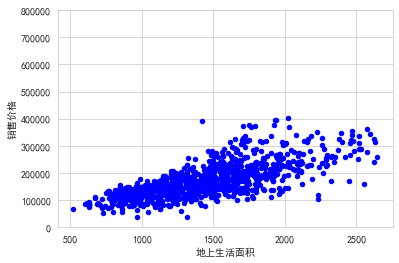

In [133]:
# 从上面的print中挑选一个画图看看
# 一般认为房子面积越大，售价越高，从图上看大致也是这个趋势。
var ='地上生活面积'
data = pd.concat([train_data['销售价格'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='销售价格', ylim=(0, 800000), color='blue')

In [134]:
# 用模型来决出最重要的一批指标
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

df_encoded = train_data.copy()
for col in df_encoded.select_dtypes('object').columns:
    df_encoded[col] = pd.factorize(df_encoded[col])[0]

X = df_encoded.drop(['销售价格', '编号'], axis=1)
y = df_encoded['销售价格']

model = LGBMRegressor()
model.fit(X, y)

# 查看特征重要性
importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(20))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3608
[LightGBM] [Info] Number of data points in the train set: 1027, number of used features: 72
[LightGBM] [Info] Start training from score 170339.771178
总生活面积       219
车库面积        187
地块面积        155
地下室未装修面积    130
房龄          127
地下室装修面积1    124
一层面积        122
地下室总面积      111
临街长度        109
街区          101
地上生活面积       99
木质甲板面积       97
整体状况         72
车库建造年        71
翻新年份         70
砌面面积         69
建造年份         69
街区_住宅风格      67
整体材质         66
开放式门廊面积      63
dtype: int32


可见这两种方法选出的特征类非常不同

接下来就是模型训练了。



In [135]:
top_20_features = importances.sort_values(ascending=False).head(20).index.tolist()
X_train = train_data[top_20_features]
y_train = train_data[TARGET]
X_test = test_data[top_20_features]

In [136]:
X_train.columns

Index(['总生活面积', '车库面积', '地块面积', '地下室未装修面积', '房龄', '地下室装修面积1', '一层面积', '地下室总面积',
       '临街长度', '街区', '地上生活面积', '木质甲板面积', '整体状况', '车库建造年', '翻新年份', '砌面面积',
       '建造年份', '街区_住宅风格', '整体材质', '开放式门廊面积'],
      dtype='object')

In [137]:
# 划分验证集，自我评估0.1208, 比init.ipynb的0.1442要好，但是得分却比init.ipynb多了0.02
# X_train_split, X_valid, y_train_split, y_valid = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=42
# )
# # 1. 自动识别所有非数值列（object 或 category 类型）
# cat_cols = X_train_split.select_dtypes(include=['object', 'category']).columns.tolist()
#
# # 2. 对训练集、验证集、测试集进行独热编码
# X_train_encoded = pd.get_dummies(X_train_split, columns=cat_cols, drop_first=True)
# X_valid_encoded = pd.get_dummies(X_valid, columns=cat_cols, drop_first=True)
# X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
#
# # 3. 对齐验证集和测试集的列，使其与训练集完全一致
# X_valid_encoded = X_valid_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
# X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
#
# # 4. 建模
# model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
# model.fit(X_train_encoded, y_train_split)
#
# # 5. 验证集预测与评估
# y_pred = model.predict(X_valid_encoded)
# log_mse = mean_squared_error(np.log1p(y_valid), np.log1p(y_pred))
# log_rmse = np.sqrt(log_mse)
# print(f"验证集上的对数 RMSE：{log_rmse:.4f}")


In [138]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import uniform, randint

X_train_split, X_valid, y_train_split, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# adding...
# 1. 自动识别所有非数值列（object 或 category 类型）
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# 2. 对训练集和测试集进行独热编码
X_train_encoded = pd.get_dummies(X_train_split, columns=cat_cols, drop_first=True)
X_valid_encoded = pd.get_dummies(X_valid, columns=cat_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# 3. 对齐验证集和测试集的列，使其与训练集完全一致
X_valid_encoded = X_valid_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# 自定义评估函数：log RMSE（与前面一致）
def rmse_log_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

# 包装为 scorer，越小越好，需加 greater_is_better=False
rmse_scorer = make_scorer(rmse_log_score, greater_is_better=False)

# 参数搜索空间
param_dist = {
    'n_estimators': randint(100, 2000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(2, 10),
    'min_child_weight': uniform(1, 6),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.3, 0.7),
    'colsample_bytree': uniform(0.3, 0.7),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

# 初始化模型
xgb_model = XGBRegressor(tree_method='hist', random_state=42)

# 随机搜索（可调 n_iter 次数）
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring=rmse_scorer,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 执行搜索
random_search.fit(X_train_encoded, y_train_split)

# 输出最优参数
print("Best Parameters:", random_search.best_params_)

# 使用最佳模型进行预测
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_valid_encoded)
log_rmse = np.sqrt(mean_squared_error(np.log1p(y_valid), np.log1p(y_pred)))
print(f"验证集上的最佳对数 RMSE：{log_rmse:.4f}")

# 最终预测（可选）
final_preds = best_model.predict(X_test_encoded)
submission = pd.DataFrame({
    'Id': test_data['编号'],
    'SalePrice': final_preds
})
submission.to_csv('submission_tuned_after_eda.csv', index=False)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.8min finished


Best Parameters: {'colsample_bytree': 0.3485529106126158, 'gamma': 0.050389000688713326, 'learning_rate': 0.015466547695464919, 'max_depth': 4, 'min_child_weight': 4.709523306027357, 'n_estimators': 826, 'reg_alpha': 0.07118864846022899, 'reg_lambda': 0.3189756302937613, 'subsample': 0.8914127176786182}
验证集上的最佳对数 RMSE：0.1092


In [139]:
# 1. 自动识别所有非数值列（object 或 category 类型）
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# 2. 对训练集和测试集进行独热编码
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# 3. 对齐测试集，使其与训练集完全一致
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# 4. 建模（全量训练）
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train_encoded, y_train)

# 5. 用于测试集预测（假设你之后想提交或评估）
y_test_pred = model.predict(X_test_encoded)

In [140]:
# 预测
preds = model.predict(X_test_encoded)

# 6. 输出结果（如果你打算提交）
submission = pd.DataFrame({
    'Id': test_data['编号'],
    'SalePrice': preds
})
submission.to_csv('submission.csv', index=False)